# The problem statement:
* Building a model that can predicting the price of a house based on the given characteristics with hiugh accuracy. 
* We will to use a structured dataset extracted from the 1990 Census that included details on housing, available from Geron's  git hub page. Aurelien Geron is the author of The Hands On Machine Learning ... (O'Reilly Media).
## About the data:
*District-level data, median. 
*Many values are capped, e.g. age at 52, income at 15 (X 10,000 USD), house value at 500,000.


## Preamble

In [1]:
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
cwd = os.getcwd()
IMAGES_PATH = os.path.join(cwd,"images")
try:
    os.mkdir(IMAGES_PATH)
except OSError as error: 
    print('Directory already exists')  

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Directory already exists


## Explore Data: make a dataframe

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


ocean_proximity is an object, rest are numbers
\
total_bedrooms may have NaN

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing["total_bedrooms"].isna().value_counts()
# 207 NA
# will have to be imputed before we can continue

False    20433
True       207
Name: total_bedrooms, dtype: int64

Data does not have an id for each house, we can use the index as a column to make these identifiers

In [10]:
housing_with_id = housing.reset_index() 

In [11]:
housing_with_id.describe()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,10319.500000,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,5958.399114,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,0.000000,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,5159.750000,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,10319.500000,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,15479.250000,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,20639.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Explore Data: summary stats/ graphs of each feature

Saving figure attribute_histogram_plots


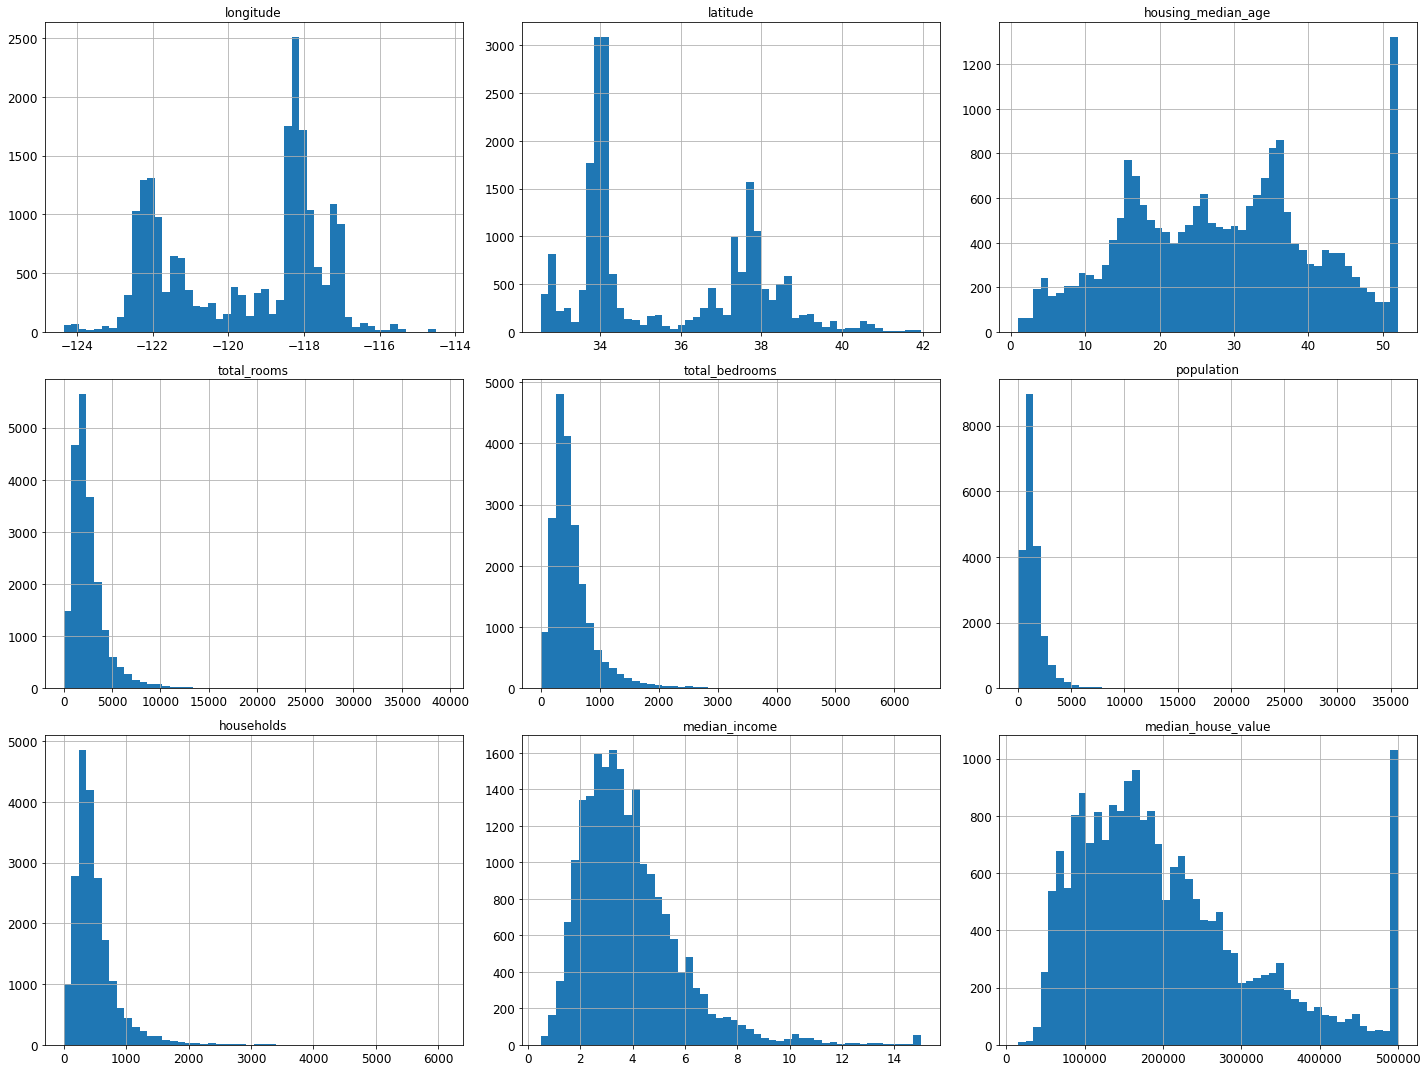

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Building A Model

We will keep some part of the data untouched to test how well the model works with outside data by splitting the dataset. Let's startify this split using income and house value.

In [13]:
housing['income_cat']=pd.cut(housing['median_income'], bins=[0,1.5,3,4.5,6,np.inf],labels=[1,2,3,4,5])

In [14]:
housing['house_val_cat']=pd.cut(housing['median_house_value'], bins=[0,100000,200000,300000,400000,np.inf],labels=[1,2,3,4,5])

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat'], housing['house_val_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
strat_train_set['income_cat'].value_counts()/len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [18]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [19]:
strat_train_set['house_val_cat'].value_counts()/len(strat_train_set)

2    0.403464
3    0.234859
1    0.175993
4    0.099806
5    0.085877
Name: house_val_cat, dtype: float64

In [20]:
strat_test_set['house_val_cat'].value_counts()/len(strat_test_set)

2    0.390262
3    0.241037
1    0.182171
4    0.107558
5    0.078973
Name: house_val_cat, dtype: float64

In [21]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis=1, inplace=True)
    set_.drop("house_val_cat", axis=1, inplace=True)

In [22]:
housing_data=strat_train_set.copy()

In [23]:
test_data=strat_test_set.copy()

### Visualizing data relationships

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

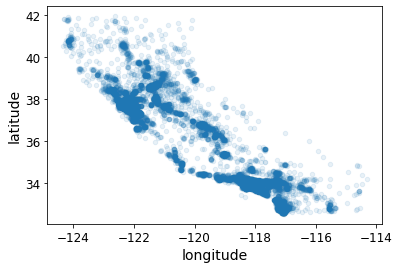

In [24]:
housing_data.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

Shows that data is not equally distributed by grapgraphy

Housing population and prices distribution by geography: size of the circle is population, color is housing prices

Saving figure pop_density_house_prices_geography


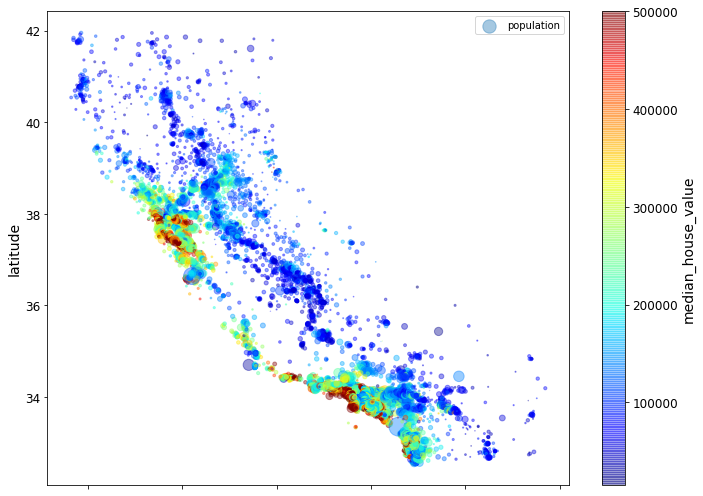

In [25]:
housing.plot(kind='scatter', x='longitude',y='latitude',alpha=0.4,
             s=housing['population']/100, 
             c='median_house_value',
             label='population',
             figsize=(10,7),
             cmap=plt.get_cmap('jet'),
             colorbar=True
            )
plt.legend()
save_fig("pop_density_house_prices_geography")

### Correlations 

In [26]:
corr_matrix=housing_data.corr()

In [27]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Highest correlation with income of the place, then with size of the house, age. Negative correlation with population. 

In [28]:
from pandas.plotting import scatter_matrix

In [29]:
attributes=['median_house_value','median_income','total_rooms','housing_median_age']

Saving figure scatter_matrix


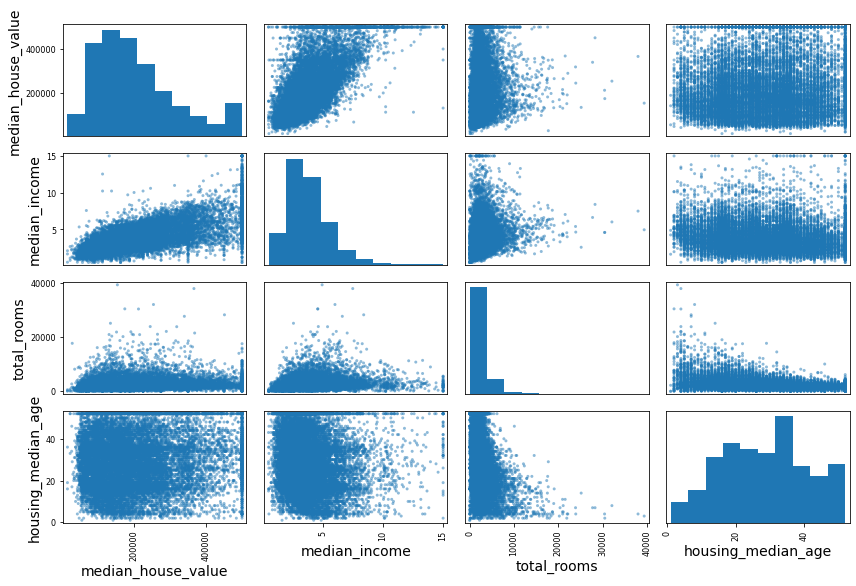

In [30]:
scatter_matrix(housing_data[attributes], figsize=(12,8))
save_fig("scatter_matrix")

In [31]:
corr_matrix=housing_data.corr()

In [32]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [33]:
X=housing_data.copy()
y=X.pop('median_house_value')

### Pipeline for numerical columns

We will do the following transformations for cols with numerical data, respectively:
* impute missing values using simple imputer
* create new features by combining old features
* standardize the features


In [34]:
from sklearn.impute import SimpleImputer

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

In [37]:
rooms_ix, beds_ix, pop_ix, hh_ix = 3,4,5,6
# column no. of the housing_data that correspond to features we will use

class CombinedAttrAdder(BaseEstimator,TransformerMixin):
    def __init__(self):
        self
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        rooms_per_hh=X[:,rooms_ix]/X[:,hh_ix]
        bedrooms_per_room=X[:,beds_ix]/X[:,rooms_ix]
        pop_per_hh=X[:,pop_ix]/X[:,hh_ix]
        return np.c_[X,rooms_per_hh,pop_per_hh,bedrooms_per_room]


In [38]:
attr_adder=CombinedAttrAdder()

Check if the attr_adder is working

In [39]:
attr_adder.fit(X.values)

CombinedAttrAdder()

In [40]:
temp=attr_adder.transform(X.values)

In [41]:
X_extra=pd.DataFrame(temp,columns=np.append(X.columns,['rooms_per_hh','bedrooms_per_room','pop_per_hh']))

In [42]:
X_extra

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_hh,bedrooms_per_room,pop_per_hh
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395,0.223852
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965,0.159057
2,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974,0.241291
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977,0.200866
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847,0.231341
...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.2,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND,6.052381,2.728571,0.185681
16508,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND,4.635659,4.077519,0.245819
16509,-116.4,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND,6.346405,2.742484,0.179609
16510,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN,5.505618,3.808989,0.193878


It's working fine

In [43]:
from sklearn.pipeline import Pipeline

In [44]:
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attr_adder',CombinedAttrAdder()),
    ('std_scaler',StandardScaler())
])

### Pipeline for non-numerical columns:

We will only do the following transformations for cols with nonnumerical data, respectively: 
* impute missing values using simple imputer strategy of most_frequent
* encode using onehot encoder

In [45]:
from sklearn.preprocessing import OneHotEncoder

In [46]:
nonnum_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('OH',OneHotEncoder())
])

### Complete Pre-processing Pipleline

In [47]:
from sklearn.compose import ColumnTransformer
num_cols=['longitude','latitude','housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
nonnum_cols=['ocean_proximity']

In [48]:
preprocess_pipeline=ColumnTransformer([
    ('num',num_pipeline,num_cols),
    ('nonnum',nonnum_pipeline,nonnum_cols)
],remainder='passthrough')

In [49]:
temp_array=preprocess_pipeline.fit_transform(X)

In [50]:
nonnum_colnames=[]
for i in nonnum_cols:
    nonnum_colnames=nonnum_colnames+list(X[i].value_counts().keys())

In [51]:
nonnum_colnames

['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']

In [52]:
new_cols=['rooms_per_hh','bedrooms_per_room','pop_per_hh']

In [53]:
cols=num_cols+ new_cols +nonnum_colnames

In [54]:
cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hh',
 'bedrooms_per_room',
 'pop_per_hh',
 '<1H OCEAN',
 'INLAND',
 'NEAR OCEAN',
 'NEAR BAY',
 'ISLAND']

In [55]:
X_prep=pd.DataFrame(temp_array, columns=cols)

In [56]:
X_prep

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_hh,bedrooms_per_room,pop_per_hh,<1H OCEAN,INLAND,NEAR OCEAN,NEAR BAY,ISLAND
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.722267,-0.673331,1.379547,-0.632123,-0.725361,-0.759010,-0.764049,0.554158,0.234352,-0.031755,-0.428853,0.0,1.0,0.0,0.0,0.0
16508,1.007011,-0.823004,0.902385,-0.667196,-0.584183,-0.329664,-0.636291,-0.948815,-0.308114,0.084689,0.491503,0.0,1.0,0.0,0.0,0.0
16509,1.586489,-0.724781,-1.562952,1.043901,0.822735,0.607904,0.713156,-0.316705,0.346934,-0.030554,-0.521776,0.0,1.0,0.0,0.0,0.0
16510,0.782213,-0.851068,0.186642,-0.309919,-0.374849,-0.057178,-0.375451,0.098121,0.024995,0.061509,-0.303407,1.0,0.0,0.0,0.0,0.0


## Model selection

In this notebook I will try and test: 
* linear regressor
* random forest regressor

For cross validation of these models, I will use Scikit-Learn's K-fold cross-validation feature, K=10

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
lin_reg=LinearRegression()

In [59]:
from sklearn.model_selection import cross_val_score

In [60]:
scores=cross_val_score(lin_reg,X_prep,y,scoring='neg_mean_squared_error',cv=10)

In [61]:
lin_reg_rmse_scores=np.sqrt(-scores)

In [62]:
print(lin_reg_rmse_scores.mean(),lin_reg_rmse_scores.std())

69052.46136345083 2731.674001798346


In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
forest_reg= RandomForestRegressor()

In [65]:
forest_reg.fit(X_prep,y)

RandomForestRegressor()

In [66]:
#scores=cross_val_score(forest_reg,X_prep,y,scoring='neg_mean_squared_error',cv=10)
# This takes a long time to run. I will dump it into memory so that I do not have to evaluate it again

In [67]:
forest_reg_rmse_score=np.sqrt(-scores)

In [68]:
print(forest_reg_rmse_score.mean(),forest_reg_rmse_score.std())

69052.46136345083 2731.674001798346


The RandomForestRegressor is doing much better than the LinearRegressor

## Model Tuning

We know that the RF regressor is doing much better than the LR. We can make the model a little bit better by trying to find the parameters that are the best for predictions within sample. But this may make the without model prediction worse. So, for now I am going to accept the default values of the RF regressor.

## Model Testing

In [69]:
X_test=strat_test_set.copy()
y_test=X_test.pop('median_house_value')

In [70]:
X_test_prep=preprocess_pipeline.transform(X_test)

In [71]:
forest_reg.fit(X_prep,y)

RandomForestRegressor()

In [74]:
test_pred=forest_reg.predict(X_test_prep)

In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
rmse=np.sqrt(mean_squared_error(test_pred,y_test))
rmse

48274.66038104131

If we also need confidence intervals, say 95%

In [79]:
sq_err=(test_pred-y_test)**2
rmse=(sq_err.sum()/len(test_pred))**0.5
rmse

48274.66038104131

In [80]:
from scipy import stats

In [81]:
np.sqrt(stats.t.interval(0.95,len(sq_err) -1, loc=sq_err.mean(),scale=stats.sem(sq_err)))

array([46236.82487157, 50229.88846898])

## Complete Pipeline: preprocessing, fitting model, and predicting

In [82]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", preprocess_pipeline),
        ("forest", RandomForestRegressor())
    ])
full_pipeline_with_predictor.fit(X, y)

Pipeline(steps=[('preparation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attr_adder',
                                                                   CombinedAttrAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                

In [84]:
my_model = full_pipeline_with_predictor

In [87]:
test_pred=my_model.predict(X_test)

In [88]:
sq_err=(test_pred-y_test)**2
rmse=(sq_err.sum()/len(test_pred))**0.5
rmse

48342.423730862596